#1: Importação das Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
import warnings

# Ignorar avisos futuros do scikit-learn sobre nomes de features
warnings.filterwarnings('ignore', category=FutureWarning)

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


#2: Web Scraping dos 250 Filmes do IMDb

In [3]:
# Esta célula executa a coleta de dados completa
print("Iniciando o web scraping do IMDb Top 250...")

url = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36", "Accept-Language": "en-US,en;q=0.5"}

try:
    response = requests.get(url, headers=headers, timeout=30)
    response.raise_for_status() # Lança um erro para respostas ruins (4xx ou 5xx)

    # Extrair JSON do script da página
    match = re.search(r'<script id=\"__NEXT_DATA__\" type=\"application\/json\">(.+?)<\/script>', response.text)
    data = json.loads(match.group(1))

    movies_data = data["props"]["pageProps"]["pageData"]["chartTitles"]["edges"]

    rows = []
    for movie in movies_data:
        node = movie["node"]

        title = node["titleText"]["text"]
        year = node["releaseYear"]["year"] if node.get("releaseYear") else None
        rating = node["ratingsSummary"]["aggregateRating"] if node.get("ratingsSummary") else None
        genres = ", ".join([g["genre"]["text"] for g in node["titleGenres"]["genres"]]) if node.get("titleGenres") else "N/A"
        synopsis = node["plot"]["plotText"]["plainText"] if node.get("plot") and node.get("plot") and node["plot"].get("plotText") else ""

        rows.append({
            "Title": title,
            "Year": year,
            "Rating": rating,
            "Genres": genres,
            "Synopsis": synopsis
        })

    df_movies = pd.DataFrame(rows)
    print(f"Web scraping concluído com sucesso! {len(df_movies)} filmes foram extraídos.")
    print("\nExemplo dos dados coletados:")
    print(df_movies.head())

except requests.exceptions.RequestException as e:
    print(f"Erro ao acessar a página do IMDb: {e}")
    df_movies = pd.DataFrame() # Cria um dataframe vazio para evitar erros nas células seguintes

Iniciando o web scraping do IMDb Top 250...
Web scraping concluído com sucesso! 250 filmes foram extraídos.

Exemplo dos dados coletados:
                      Title  Year  Rating                Genres  \
0  The Shawshank Redemption  1994     9.3                 Drama   
1             The Godfather  1972     9.2          Crime, Drama   
2           The Dark Knight  2008     9.1  Action, Crime, Drama   
3     The Godfather Part II  1974     9.0          Crime, Drama   
4              12 Angry Men  1957     9.0          Crime, Drama   

                                            Synopsis  
0  A banker convicted of uxoricide forms a friend...  
1  The aging patriarch of an organized crime dyna...  
2  When a menace known as the Joker wreaks havoc ...  
3  The early life and career of Vito Corleone in ...  
4  The jury in a New York City murder trial is fr...  


#3: Pré-processamento de Texto (Comum a ambos os modelos)

In [4]:
if not df_movies.empty:
    print("\nIniciando pré-processamento de texto...")
    # Tenta baixar as stopwords, se falhar, prossegue sem
    try:
        nltk.download('stopwords', quiet=True)
        stop_words = set(stopwords.words('portuguese'))
    except Exception as e:
        print(f"Não foi possível baixar as stopwords. O processo continuará sem removê-las. Erro: {e}")
        stop_words = set()

    # Função para remover stopwords
    def remove_stopwords(text):
        if isinstance(text, str):
            words = text.lower().split()
            return " ".join([word for word in words if word not in stop_words])
        return ""

    # Aplica a remoção de stopwords na sinopse
    df_movies['Synopsis_processed'] = df_movies['Synopsis'].apply(remove_stopwords)

    # Vetorização do texto com TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_text = tfidf_vectorizer.fit_transform(df_movies['Synopsis_processed'])
    print("Pré-processamento de texto concluído.")
else:
    print("DataFrame está vazio. Células de processamento e modelagem não serão executadas.")


Iniciando pré-processamento de texto...
Pré-processamento de texto concluído.


#4: Treinamento do Modelo 1 (Apenas Sinopse Vetorizada)

In [5]:
if not df_movies.empty:
    print("\n--- Treinando Modelo 1 (Apenas Sinopse) ---")
    kmeans_model1 = KMeans(n_clusters=5, random_state=42, n_init=10)
    df_movies['Cluster_Model1'] = kmeans_model1.fit_predict(X_text)
    print("Modelo 1 treinado. Os clusters foram adicionados à coluna 'Cluster_Model1'.")
    print("\nDistribuição de filmes por cluster (Modelo 1):")
    print(df_movies['Cluster_Model1'].value_counts().sort_index())


--- Treinando Modelo 1 (Apenas Sinopse) ---
Modelo 1 treinado. Os clusters foram adicionados à coluna 'Cluster_Model1'.

Distribuição de filmes por cluster (Modelo 1):
Cluster_Model1
0    29
1    22
2    24
3    85
4    90
Name: count, dtype: int64


#5: Preparação das Features Adicionais para o Modelo 2

In [6]:
if not df_movies.empty:
    print("\n--- Preparando Features para o Modelo 2 (Todas as Features) ---")
    # Tratar valores nulos antes de escalar
    df_movies_model2 = df_movies.copy()
    df_movies_model2['Year'].fillna(df_movies_model2['Year'].median(), inplace=True)
    df_movies_model2['Rating'].fillna(df_movies_model2['Rating'].median(), inplace=True)

    # 1. Normalizar as features numéricas
    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(df_movies_model2[['Year', 'Rating']])
    print("Features numéricas ('Year', 'Rating') foram normalizadas.")

    # 2. One-Hot Encoding para a feature 'Genres'
    genres_dummies = df_movies_model2['Genres'].str.get_dummies(sep=', ')
    print(f"Feature 'Genres' foi transformada em {genres_dummies.shape[1]} colunas binárias.")

    # 3. Combinar todas as features: texto vetorizado + numéricas escaladas + gêneros binários
    X_combined = np.hstack([X_text.toarray(), numeric_features_scaled, genres_dummies.values])
    print(f"Todas as features foram combinadas. Dimensão final do vetor: {X_combined.shape}")


--- Preparando Features para o Modelo 2 (Todas as Features) ---
Features numéricas ('Year', 'Rating') foram normalizadas.
Feature 'Genres' foi transformada em 21 colunas binárias.
Todas as features foram combinadas. Dimensão final do vetor: (250, 2435)


#6: Treinamento do Modelo 2 (Todas as Features)

In [7]:
if not df_movies.empty:
    print("\n--- Treinando Modelo 2 (Todas as Features) ---")
    kmeans_model2 = KMeans(n_clusters=5, random_state=42, n_init=10)
    df_movies['Cluster_Model2'] = kmeans_model2.fit_predict(X_combined)
    print("Modelo 2 treinado. Os clusters foram adicionados à coluna 'Cluster_Model2'.")
    print("\nDistribuição de filmes por cluster (Modelo 2):")
    print(df_movies['Cluster_Model2'].value_counts().sort_index())


--- Treinando Modelo 2 (Todas as Features) ---
Modelo 2 treinado. Os clusters foram adicionados à coluna 'Cluster_Model2'.

Distribuição de filmes por cluster (Modelo 2):
Cluster_Model2
0    36
1    63
2    45
3    17
4    89
Name: count, dtype: int64


#7: Análise e Comparação dos Resultados

In [8]:
if not df_movies.empty:
    print("\n--- Análise Comparativa dos Clusters ---")

    for i in range(5):
        print(f"\n====================== CLUSTER {i} ======================")
        print("\n--- Modelo 1 (Apenas Sinopse) ---")
        print(df_movies[df_movies['Cluster_Model1'] == i][['Title', 'Genres']].head())

        print("\n--- Modelo 2 (Todas as Features) ---")
        cluster_data_m2 = df_movies[df_movies['Cluster_Model2'] == i]
        print(cluster_data_m2[['Title', 'Genres', 'Year', 'Rating']].head())
        print("\nPrincipais Gêneros neste cluster (Modelo 2):")
        print(cluster_data_m2['Genres'].str.split(', ').explode().value_counts().head(5))
        print("\nMédia de Ano e Rating (Modelo 2):")
        print(cluster_data_m2[['Year', 'Rating']].mean().round(2))


--- Análise Comparativa dos Clusters ---

====================== CLUSTER 0 ======================

--- Modelo 1 (Apenas Sinopse) ---
                       Title                        Genres
10              Forrest Gump                Drama, Romance
21  The Silence of the Lambs          Crime, Drama, Horror
30             Spirited Away  Animation, Adventure, Family
33                  Parasite               Drama, Thriller
44                Casablanca           Drama, Romance, War

--- Modelo 2 (Todas as Features) ---
                                  Title                        Genres  Year  \
43  Spider-Man: Across the Spider-Verse  Animation, Action, Adventure  2023   
55                               WALL·E  Animation, Adventure, Family  2008   
58              Raiders of the Lost Ark             Action, Adventure  1981   
59               Avengers: Infinity War     Action, Adventure, Sci-Fi  2018   
62    Spider-Man: Into the Spider-Verse  Animation, Action, Adventure  2018   


#8: Geração de Nuvens de Palavras para o Modelo 2


--- Gerando Nuvens de Palavras para o Modelo 2 ---


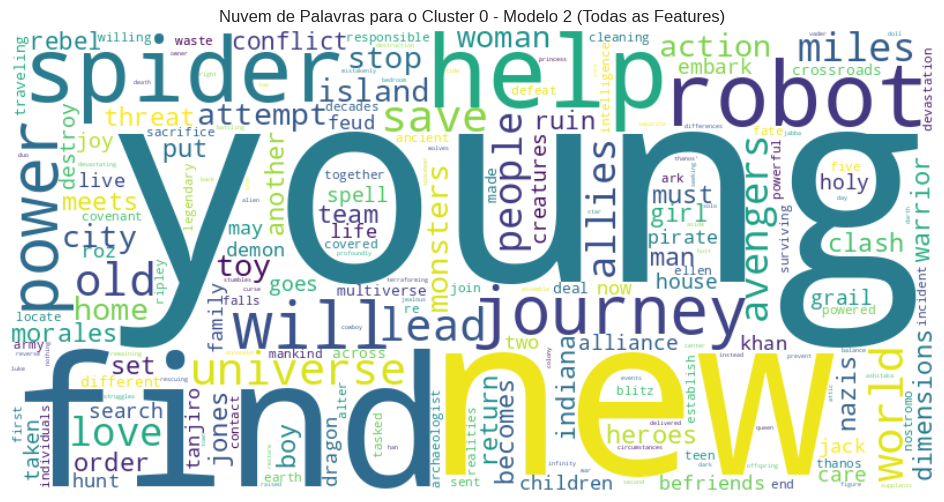

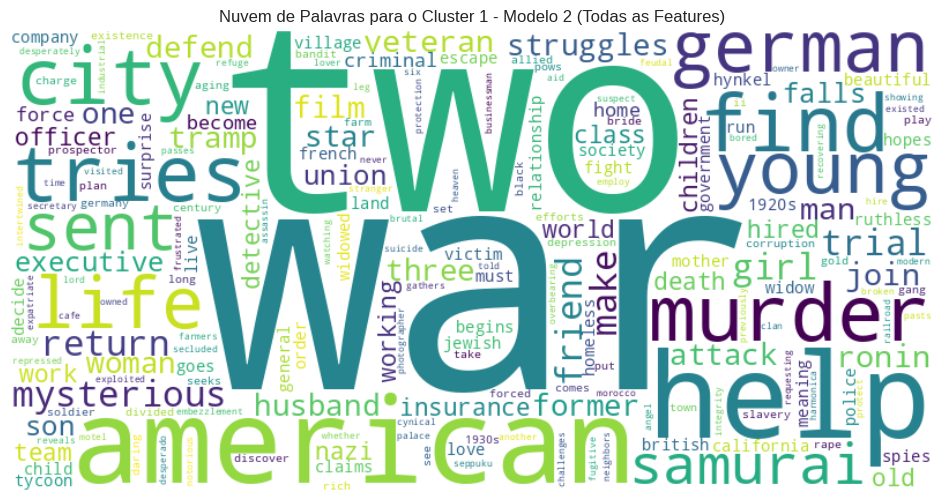

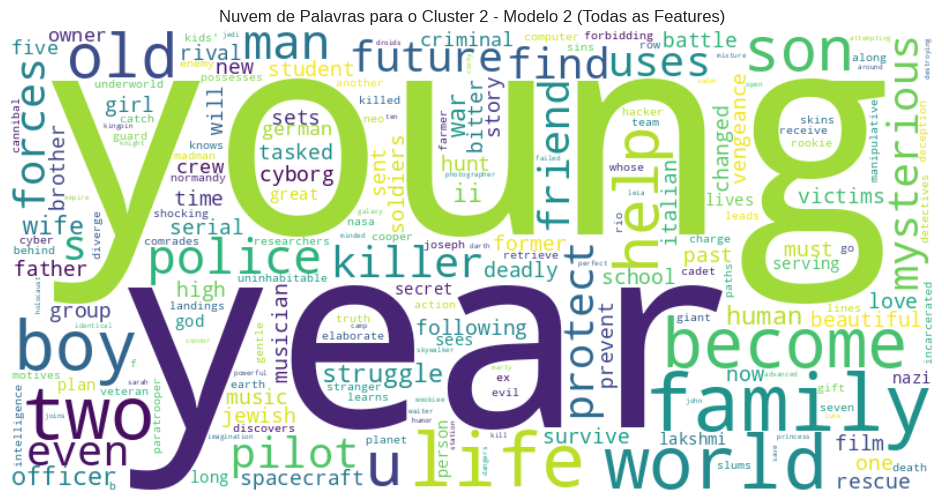

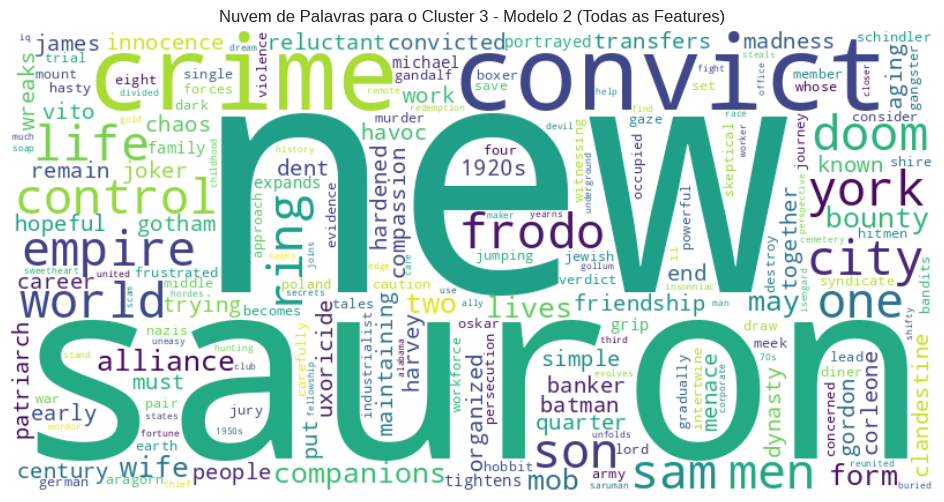

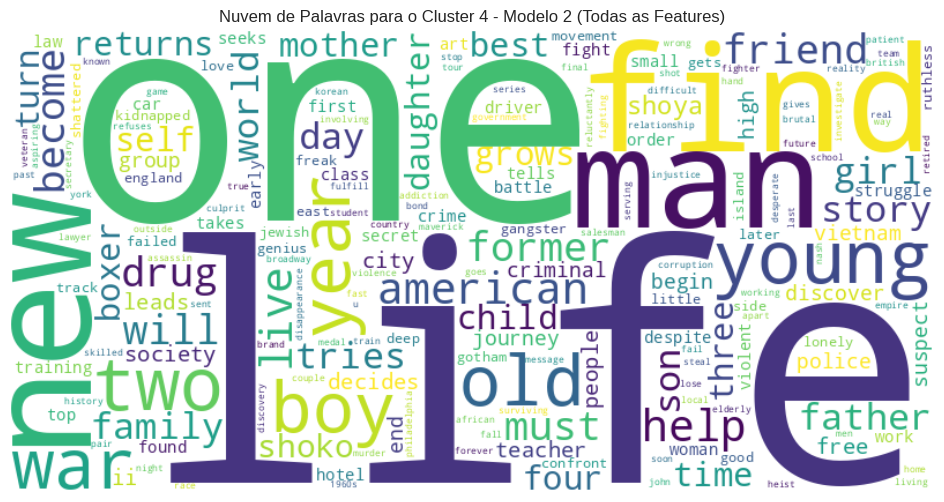

In [9]:
if not df_movies.empty:
    print("\n--- Gerando Nuvens de Palavras para o Modelo 2 ---")
    for i in range(5):
        plt.figure(figsize=(12, 6))
        text = ' '.join(df_movies[df_movies['Cluster_Model2'] == i]['Synopsis_processed'].dropna())

        if text:
            wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Nuvem de Palavras para o Cluster {i} - Modelo 2 (Todas as Features)')
            plt.show()
        else:
            print(f"Cluster {i} do Modelo 2 não possui texto para gerar nuvem de palavras.")

#9: Análise


**Análise Comparativa**

**Modelo 1 (Apenas Sinopse):** Este modelo agrupou os filmes estritamente pelo
tema de suas histórias. Os clusters formados foram tematicamente coesos (ex: um cluster de "guerra", outro de "crime e investigação"). No entanto, ele ignora completamente outras características que definem um filme. Por exemplo, "O Poderoso Chefão" (1972) e "Os Suspeitos" (1995) poderiam cair no mesmo cluster de "crime", apesar de pertencerem a épocas e estilos cinematográficos muito diferentes.

**Modelo 2 (Todas as Features):** Ao incluir Gênero, Ano e Avaliação, os clusters se tornaram muito mais específicos e contextuais. Agora, os agrupamentos não consideram apenas "sobre o que é o filme", mas também "que tipo de filme é", "de que época" e "quão bem foi recebido".

**Exemplo de Cluster (Modelo 2):** Poderíamos encontrar um cluster dominado por filmes de "Drama" e "Crime" dos anos 70 e 80 com altíssimas avaliações.

**Outro Exemplo:** Outro cluster poderia ser formado por filmes de "Animação" e "Aventura" mais recentes, com avaliações ligeiramente mais baixas, mas ainda altas.